# A Computational Framework for Scalable Time Geographic Analysis

## Code examples and figures from paper

This is a _preview_ of very early tests. It should not even be considered _alpha_ stage code.  
Most functions should be considered 'academic' code (i.e., not yet useful for real-world analysis).

In [1]:
import matplotlib
matplotlib.use('agg')  # Only do this once
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

from hypt import HPTree, Prism, Point3, from_csv, build_tree, combine
from hypt.plotting import draw_tree_3d, draw_cone_3d, draw_prism_3d, draw_ppa

from cartopy.io.img_tiles import MapQuestOSM

## Plotting a Prism

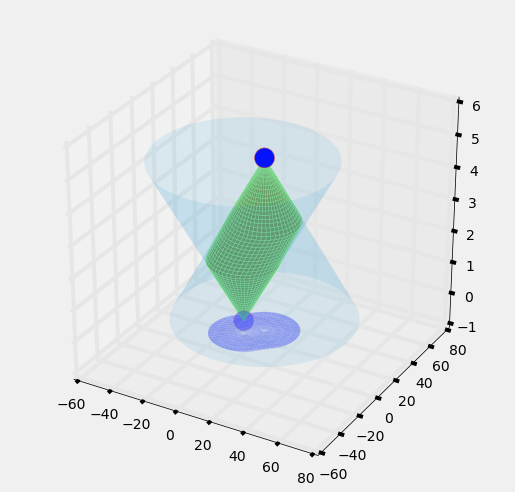

In [2]:
p = Prism((2, 2, 0), (10, 10, 5), 10)

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection="3d")

# Add the cones
draw_cone_3d(p.future_cone(), alpha=.12, color="#30a2da")
draw_cone_3d(p.past_cone(), alpha=.12, color="#30a2da")

# Add the prism
draw_prism_3d(p, alpha=.8, linewidth=0.5)

# Add the control points
ps = zip(p.p1[:], p.p2[:])
ax.scatter(*ps, color='#fc4f30', s=400)

# Add the potential path area
draw_ppa(p, alpha=.2, adjz=-.4, color="#6d904f")

plt.show()

## Working with real trajectories

In [3]:
# First, we load some data
dfs = []
root, dirs, files = list(os.walk("examples"))[0]
for name in files:
    path = os.path.join(root, name)
    track_name = name.split(".csv")[0]
    track = from_csv(path, time_col="time", loc_cols=["x", "y"],
                     vmax_col="speed", id_col="track_id")
    dfs.append(track)
df = combine(dfs)
print(df["speed"].mean())
print(df.shape)
print(df.track_id.unique().shape)

36.1436682301
(4051, 5)
(43,)


## Create 2D trajectories plot

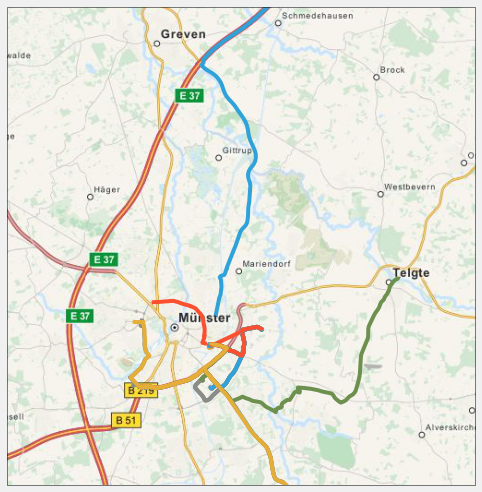

In [4]:
fig = plt.figure(figsize=(8, 8))

tiler = MapQuestOSM()
mercator = tiler.crs
ax = plt.axes(projection=mercator)
ax.set_extent([7.50, 7.85, 51.89, 52.11])

ax.add_image(tiler, 11)

for df in dfs:
    ax.plot(df.x, df.y)

plt.show()

## Create 3D trajectories plot

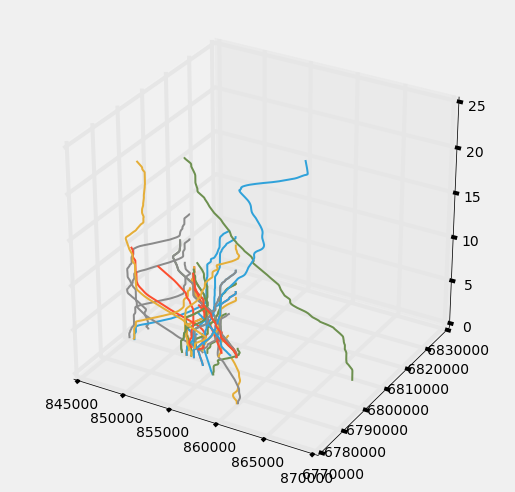

In [5]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection="3d")

for df in dfs:
    ax.plot(df.x, df.y, df.time, linewidth=2)

plt.show()

## Building a tree (nested HPT)

In [6]:
# This makes some _very_ strong assumptions!
# Takes a few seconds...
nested = [build_tree(df) for df in dfs]
tree = BVHTree(objects=nested, fatten=0.0)

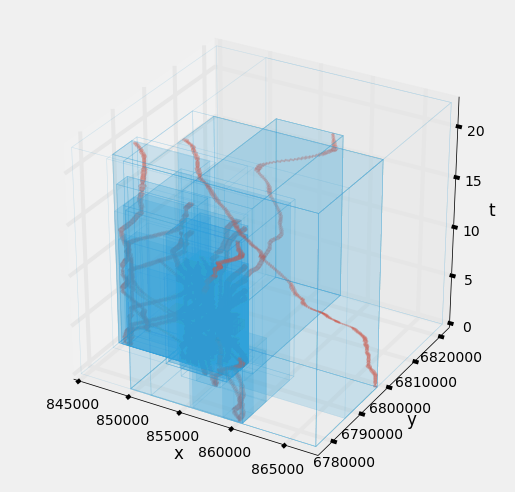

In [7]:
# Plotting in 3D is slow...
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection="3d")

draw_tree_3d(ax, tree.root, prisms=False, nested=True)

plt.show()

## Finding similar trajectories

In [8]:
# Get 'global' bounds for plotting
xlim = tree.bounds().p1.x, tree.bounds().p2.x
ylim = tree.bounds().p1.y, tree.bounds().p2.y
zlim = tree.bounds().p1.z, tree.bounds().p2.z

# Split into left and right trees
left = tree.root.left
right = tree.root.right

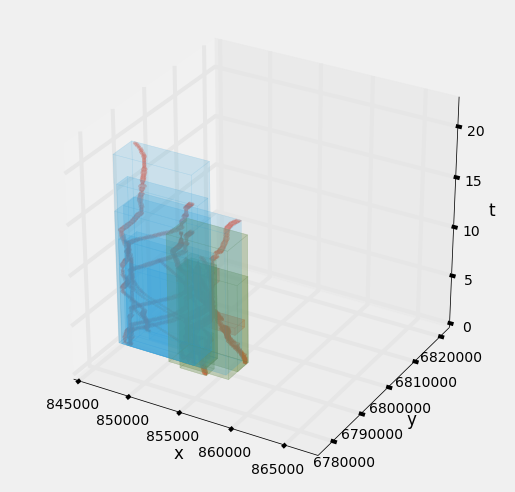

In [9]:
# Start with left sides...
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection="3d")

# Left left
draw_tree_3d(ax, left.left, nodes=False, nested=True)
# Left right
draw_tree_3d(ax, left.right, nodes=False, fill="#6d904f", stroke="#6d904f", nested=True)

# Set to 'global' extent
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.set_zlim(*zlim)

plt.show()

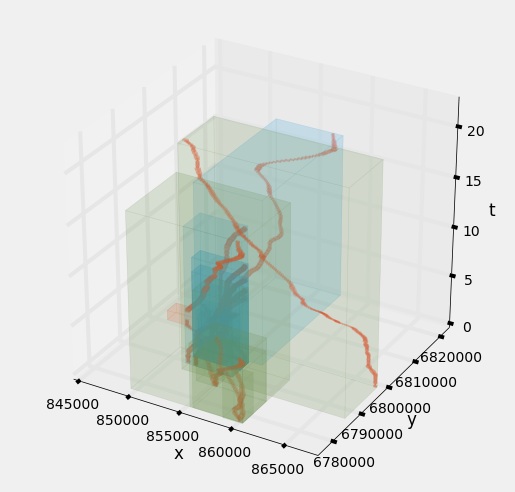

In [10]:
# End with right sides...
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection="3d")

# Right left
draw_tree_3d(ax, right.left, nodes=False, nested=True)
# Right right
draw_tree_3d(ax, right.right, nodes=False, fill="#6d904f", stroke="#6d904f", nested=True)

# Set to 'global' extent
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.set_zlim(*zlim)

plt.show()

## Computing contact points

We'll test this on a sub-tree of the second-level split on the left side.

First, we compute all contact points in this sub-tree. This demo uses higher speeds than in the paper to make things more exciting...

In [11]:
# Flatten nested tree for faster queries 
sub_tree = left.left.flatten()

# Compute contacts _and_ associated prisms
points, prisms = sub_tree.contacts()

# Grab the trajectories from the sub-tree
lines = left.left.paths()

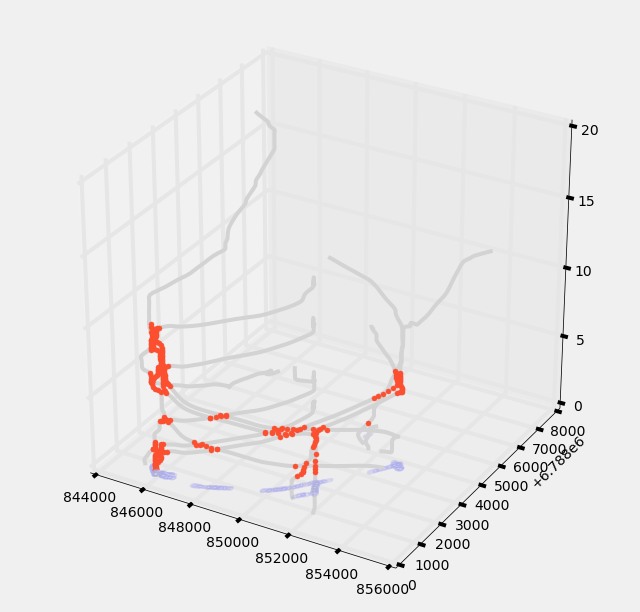

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection="3d")

# Add the PPAs
for prism in prisms:
    draw_ppa(prism, alpha=0.05, adjz=0)

# Add the trajectories
for line in lines:
    ax.plot(*zip(*line), zorder=101, c="lightgrey")

# Add the contact points
ax.plot(*zip(*points), c="#FC4F30", marker=".",
        ls='', markersize=10, zorder=102)

plt.show()

## Plotting prisms...

Turns out, this isn't really all that useful, however, we'll plot part of the longest trajectory just to show that the trees do contain prisms...

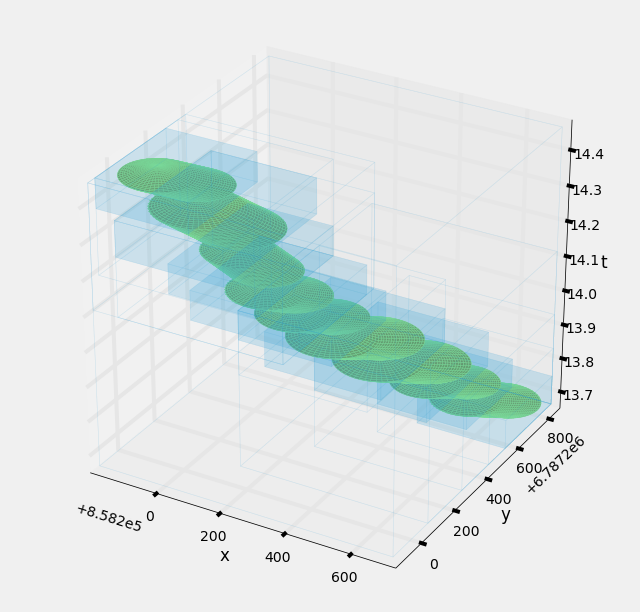

In [13]:
lengths = [t.shape[0] for t in dfs]
longest = lengths.index(max(lengths))

long_tree = build_tree(dfs[longest][152:162])  # Subset

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection="3d")

draw_tree_3d(ax, long_tree.root, prisms=True, nodes=True, boxes=True)

plt.show()

## That's all folks... stay tuned for more in the future!